In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
import warnings
warnings.filterwarnings("ignore")
import pickle

In [41]:
# Load the CSV files into DataFrames  from 1900 to 7-2024
data1 = pd.read_csv('ResaleFlatPrices1990_1999.csv')
data2 = pd.read_csv('ResaleFlatPrices2000_2012.csv')
data3 = pd.read_csv('ResaleFlatPrices2012_2014.csv')
data4 = pd.read_csv('ResaleFlatPrices2015_2016.csv')
data5 = pd.read_csv('Resaleflatprices2017onwards.csv')
# Concatenate the DataFrames
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

data.sample(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
611586,2010-06,BUKIT MERAH,3 ROOM,26,TIONG BAHRU RD,04 TO 06,88.0,Standard,1973,460000.0,NaN
458553,2005-02,QUEENSTOWN,5 ROOM,131,CLARENCE LANE,04 TO 06,121.0,Improved,1996,474000.0,NaN
796429,2019-05,TOA PAYOH,4 ROOM,139A,LOR 1A TOA PAYOH,13 TO 15,91.0,DBSS,2012,750000.0,92 years
887700,2022-01,YISHUN,4 ROOM,426C,YISHUN AVE 11,04 TO 06,92.0,Model A,2015,455000.0,92 years 02 months
356142,2001-11,TAMPINES,4 ROOM,502,TAMPINES CTRL 1,04 TO 06,105.0,Model A,1989,263000.0,NaN
470509,2005-07,CHOA CHU KANG,5 ROOM,620,CHOA CHU KANG ST 62,01 TO 03,133.0,Model A,1996,283000.0,NaN
275104,1999-09,HOUGANG,EXECUTIVE,428,HOUGANG AVE 6,07 TO 09,149.0,MAISONETTE,1990,540000.0,NaN
885063,2022-03,TOA PAYOH,4 ROOM,79C,TOA PAYOH CTRL,04 TO 06,92.0,Model A,2009,725000.0,86 years 02 months
635807,2011-03,CHOA CHU KANG,5 ROOM,546,CHOA CHU KANG ST 52,07 TO 09,119.0,Improved,1995,431000.0,NaN
535488,2007-11,HOUGANG,EXECUTIVE,407,HOUGANG AVE 10,10 TO 12,150.0,Maisonette,1986,386000.0,NaN


In [42]:
print(data.shape)
print(data.info())

(929324, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929324 entries, 0 to 929323
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                929324 non-null  object 
 1   town                 929324 non-null  object 
 2   flat_type            929324 non-null  object 
 3   block                929324 non-null  object 
 4   street_name          929324 non-null  object 
 5   storey_range         929324 non-null  object 
 6   floor_area_sqm       929324 non-null  float64
 7   flat_model           929324 non-null  object 
 8   lease_commence_date  929324 non-null  int64  
 9   resale_price         929324 non-null  float64
 10  remaining_lease      220274 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 78.0+ MB
None


In [43]:
data.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64

## Pre-Processing

1. converting month feature to year and month

2. To Fill the remaining lease value All the lease commence are 100 years
to fill the null value **lease_commence_date + 99 - current year**

3. converted the upper case and lowecase to title format

4. storey_range is like **4 TO 6** this feature converted to median storage range like **5**

5. Encoding 'town', 'flat_model', Flat_type, Address:

       EG:
       
       **Town**       :  Bedok    : 1  , Bishan         : 2
       **Flat model** :  Improved : 5.0, New Generation : 2.0
       **Flat type**  :  1 Room   : 0.0, 3 Room         :2.0

In [44]:
town_encoder = LabelEncoder()
flat_model_encoder = OrdinalEncoder()
flat_type_encoder = OrdinalEncoder()
address_encoder = LabelEncoder()


def to_upper(df):
        string_cols = df.select_dtypes(include='object').columns
        df[string_cols] = df[string_cols].apply(lambda x: x.str.upper())
        return df
    
data = (data
        .pipe(to_upper)
        .assign(month=pd.to_datetime(data["month"], format="%Y-%m"))
        .assign(year=lambda x: x["month"].dt.year,
                months=lambda x: x["month"].dt.month,
                remaining_lease= lambda x : x['lease_commence_date'] + 99 - x['year'],
                flat_type=data['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION'),
                address = lambda x : x["block"]+" "+ x["street_name"],
                town_ENCODED=lambda x: town_encoder.fit_transform(x["town"]),
                flat_model_ENCODED=lambda x: flat_model_encoder.fit_transform(x[["flat_model"]]).flatten(),
                flat_type_ENCODED=lambda x: flat_type_encoder.fit_transform(x[["flat_type"]]).flatten(),
                address_ENCODED=lambda x: address_encoder.fit_transform(x["address"])
                )
        .applymap(lambda x: x.title() if isinstance(x, str) else x)
        .assign(median_storey_range=lambda x: x['storey_range']
                .apply(lambda storey_range: (int(storey_range.split(' To ')[0]) + int(storey_range.split(' To ')[1])) / 2).astype(int))
        .pipe(to_upper)
        .drop_duplicates()
)

In [45]:
# Dump the encoders and scaler to files
with open('town_encoder.pkl', 'wb') as f:
    pickle.dump(town_encoder, f)

with open('flat_model_encoder.pkl', 'wb') as f:
    pickle.dump(flat_model_encoder, f)

with open('flat_type_encoder.pkl', 'wb') as f:
    pickle.dump(flat_type_encoder, f)

with open('address_encoder.pkl', 'wb') as f:
    pickle.dump(address_encoder, f)

In [46]:
encoded_towns = town_encoder.classes_        #label encoding so classes_
for category, code in zip(encoded_towns, range(len(encoded_towns))):
    print(f"{category} is encoded as {code}")
print("=="*20)

encoded_flat_models = flat_model_encoder.categories_      #Ordinal encoding so categories_
for category, code in zip(encoded_flat_models[0], range(len(encoded_flat_models[0]))):
    print(f"{category} is encoded as {code}")
print("=="*20)
encoded_flat_types = flat_type_encoder.categories_
for category, code in zip(encoded_flat_types[0], range(len(encoded_flat_types[0]))):
    print(f"{category} is encoded as {code}")
print("=="*20)
# encoded_address = address_encoder.classes_        #label encoding so classes_
# for category, code in zip(encoded_address, range(len(encoded_address))):
#     print(f"{category} is encoded as {code}")

ANG MO KIO is encoded as 0
BEDOK is encoded as 1
BISHAN is encoded as 2
BUKIT BATOK is encoded as 3
BUKIT MERAH is encoded as 4
BUKIT PANJANG is encoded as 5
BUKIT TIMAH is encoded as 6
CENTRAL AREA is encoded as 7
CHOA CHU KANG is encoded as 8
CLEMENTI is encoded as 9
GEYLANG is encoded as 10
HOUGANG is encoded as 11
JURONG EAST is encoded as 12
JURONG WEST is encoded as 13
KALLANG/WHAMPOA is encoded as 14
LIM CHU KANG is encoded as 15
MARINE PARADE is encoded as 16
PASIR RIS is encoded as 17
PUNGGOL is encoded as 18
QUEENSTOWN is encoded as 19
SEMBAWANG is encoded as 20
SENGKANG is encoded as 21
SERANGOON is encoded as 22
TAMPINES is encoded as 23
TOA PAYOH is encoded as 24
WOODLANDS is encoded as 25
YISHUN is encoded as 26
2-ROOM is encoded as 0
3GEN is encoded as 1
ADJOINED FLAT is encoded as 2
APARTMENT is encoded as 3
DBSS is encoded as 4
IMPROVED is encoded as 5
IMPROVED-MAISONETTE is encoded as 6
MAISONETTE is encoded as 7
MODEL A is encoded as 8
MODEL A-MAISONETTE is encoded a

In [47]:
#Cleaned data to perform EDA

cleaned_data = data[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'year', 'months', 'median_storey_range', 'town','flat_model', 'flat_type', 'address', 'resale_price']]

cleaned_data.to_csv('cleaned_data.csv',index=False)

model_data = data[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'year', 'months', 'median_storey_range','town_ENCODED','flat_model_ENCODED','flat_type_ENCODED','address_ENCODED','resale_price']]

model_data.to_csv('model_data.csv',index=False)

In [48]:
cleaned_data.head(5)

,floor_area_sqm,lease_commence_date,remaining_lease,year,months,median_storey_range,town,flat_model,flat_type,address,resale_price
0,31.0,1977,86,1990,1,11,ANG MO KIO,IMPROVED,1 ROOM,309 ANG MO KIO AVE 1,9000.0
1,31.0,1977,86,1990,1,5,ANG MO KIO,IMPROVED,1 ROOM,309 ANG MO KIO AVE 1,6000.0
2,31.0,1977,86,1990,1,11,ANG MO KIO,IMPROVED,1 ROOM,309 ANG MO KIO AVE 1,8000.0
3,31.0,1977,86,1990,1,8,ANG MO KIO,IMPROVED,1 ROOM,309 ANG MO KIO AVE 1,6000.0
4,73.0,1976,85,1990,1,5,ANG MO KIO,NEW GENERATION,3 ROOM,216 ANG MO KIO AVE 1,47200.0


In [49]:
model_data.head(5)

,floor_area_sqm,lease_commence_date,remaining_lease,year,months,median_storey_range,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price
0,31.0,1977,86,1990,1,11,0,5.0,0.0,3835,9000.0
1,31.0,1977,86,1990,1,5,0,5.0,0.0,3835,6000.0
2,31.0,1977,86,1990,1,11,0,5.0,0.0,3835,8000.0
3,31.0,1977,86,1990,1,8,0,5.0,0.0,3835,6000.0
4,73.0,1976,85,1990,1,5,0,12.0,2.0,2373,47200.0


# EDA  

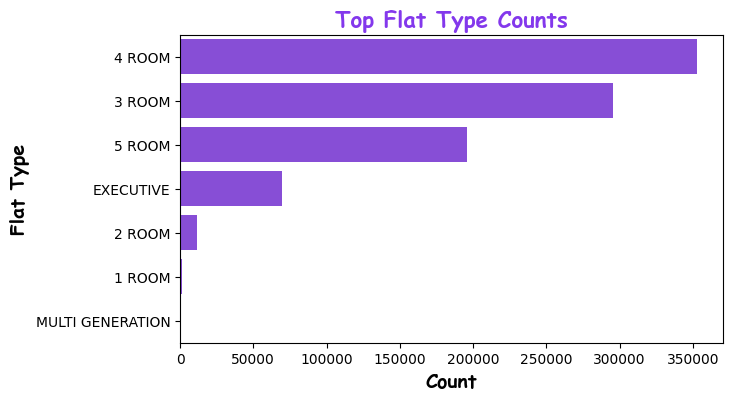

In [50]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 4))

sns.countplot(data=cleaned_data,
              y='flat_type',
              order=cleaned_data['flat_type'].value_counts().index,
              color='#8338ec', ax=ax)

ax.set_title('Top Flat Type Counts', fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')
plt.show()


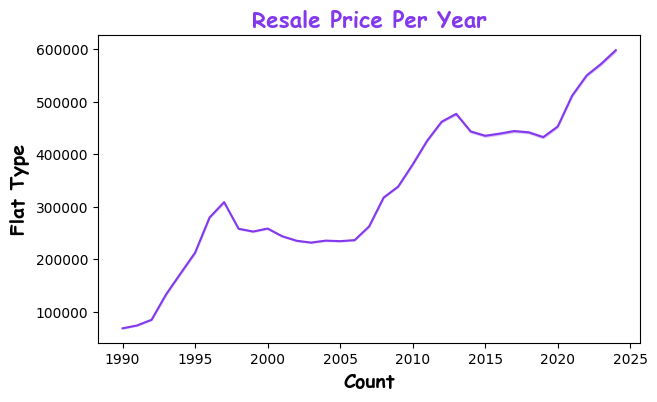

In [51]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 4))

sns.lineplot(data = model_data, x ='year', y = 'resale_price',color='#8338ec')

ax.set_title("Resale Price Per Year", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')
plt.show()

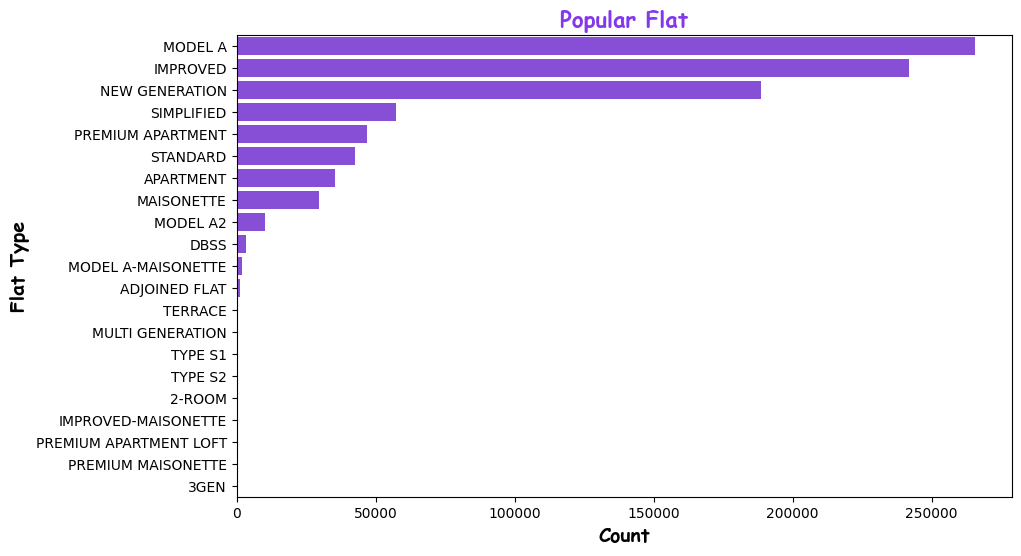

In [52]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

sns.countplot(data = cleaned_data,
              y = 'flat_model',
              order=cleaned_data['flat_model'].value_counts().index,color='#8338ec')

ax.set_title("Popular Flat", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')
plt.show()

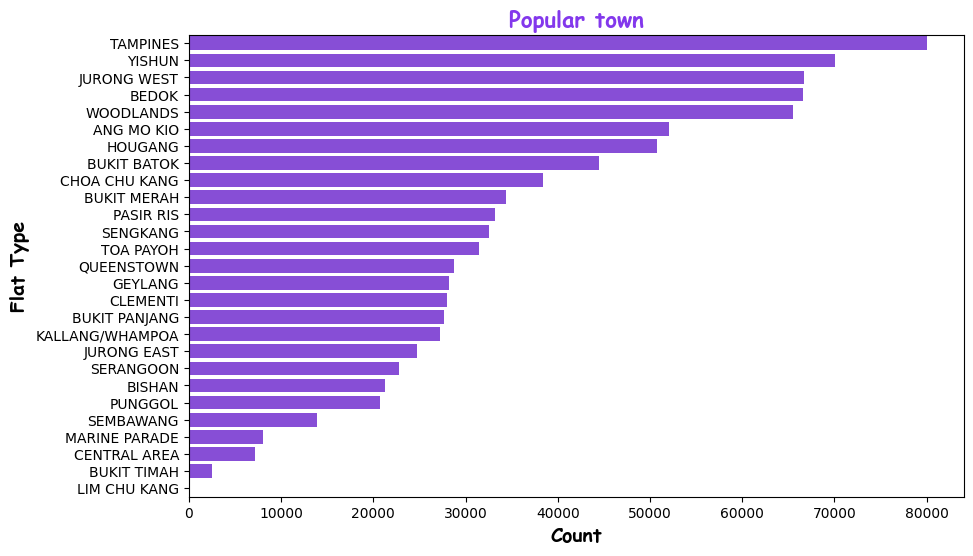

In [53]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

sns.countplot(data = cleaned_data,
              y = 'town',
              order=cleaned_data['town'].value_counts().index,color='#8338ec')

ax.set_title("Popular town", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')

# Checking Skewness and Outlayer

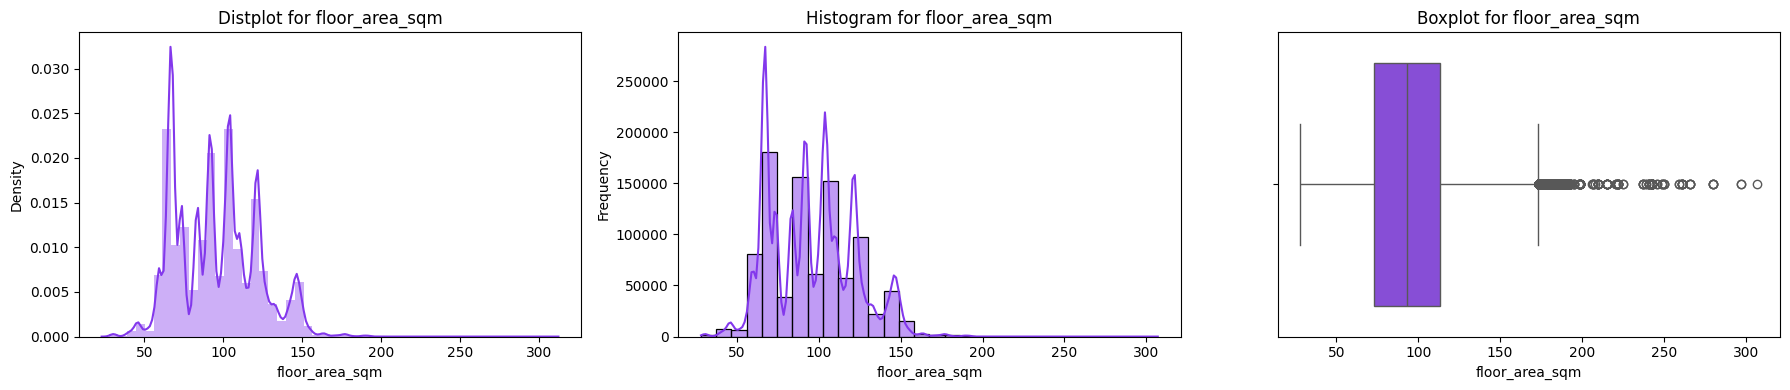

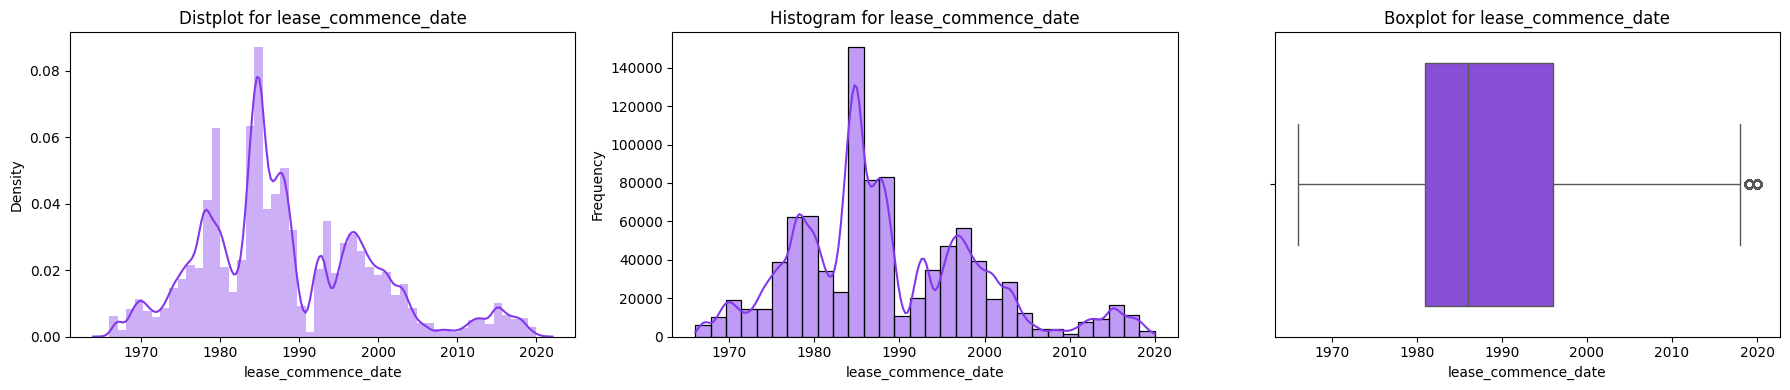

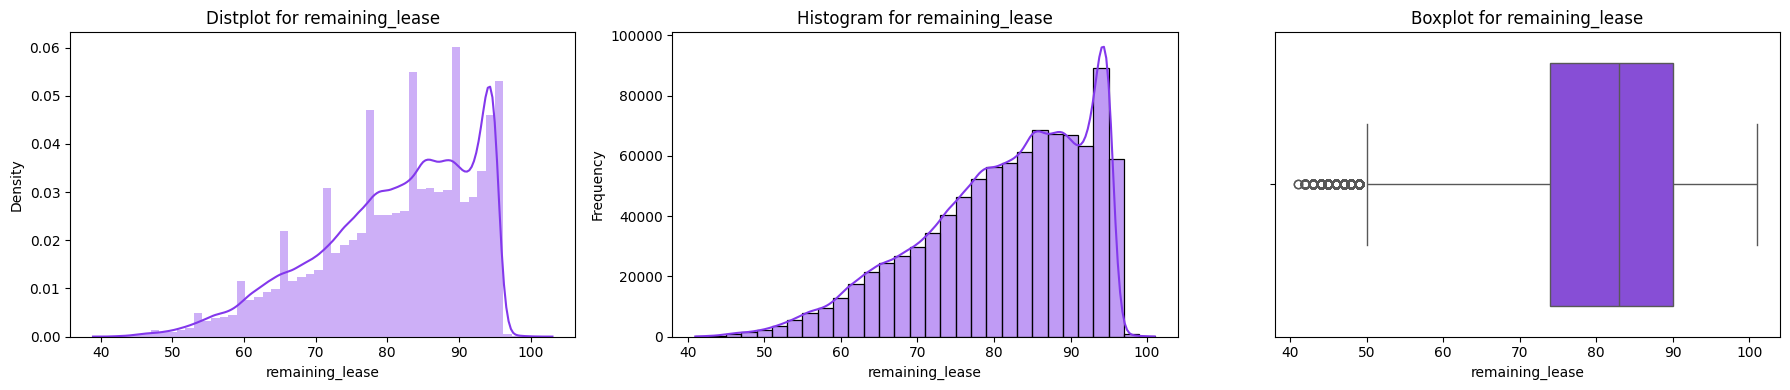

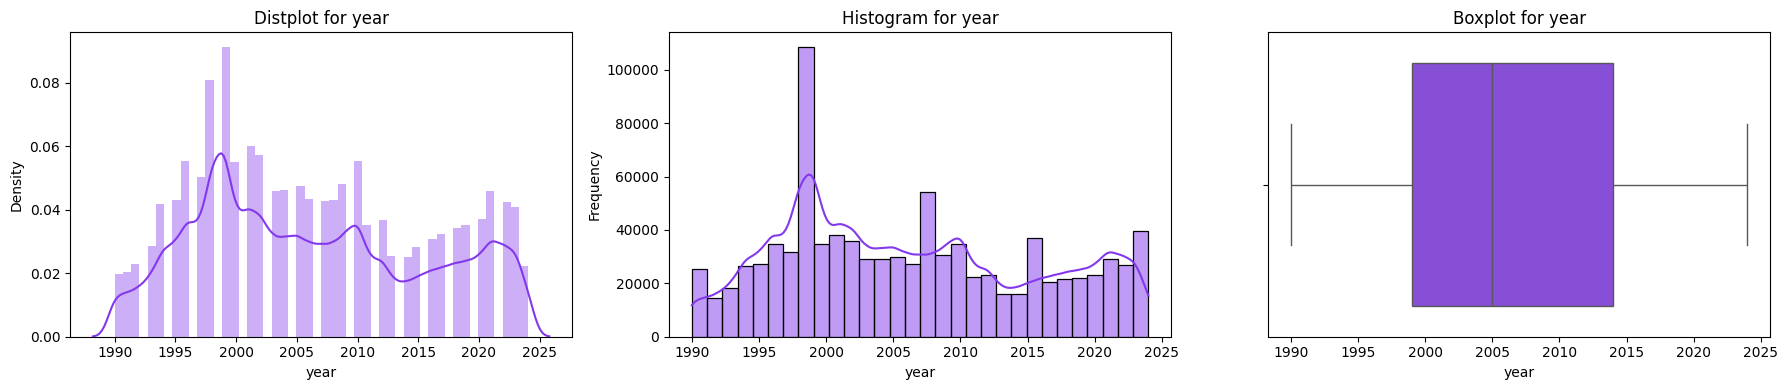

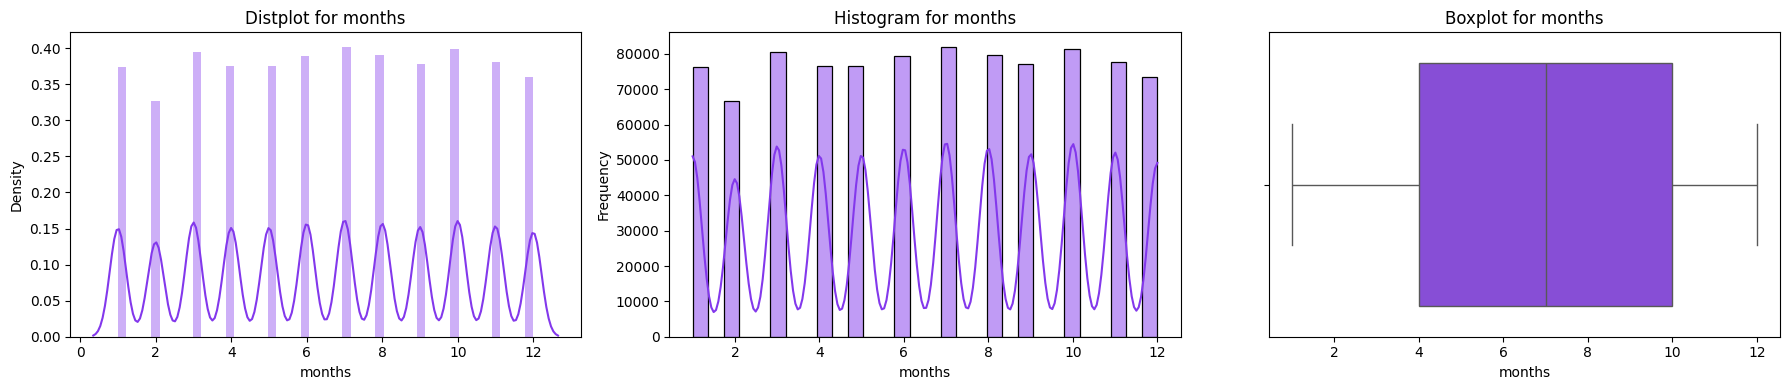

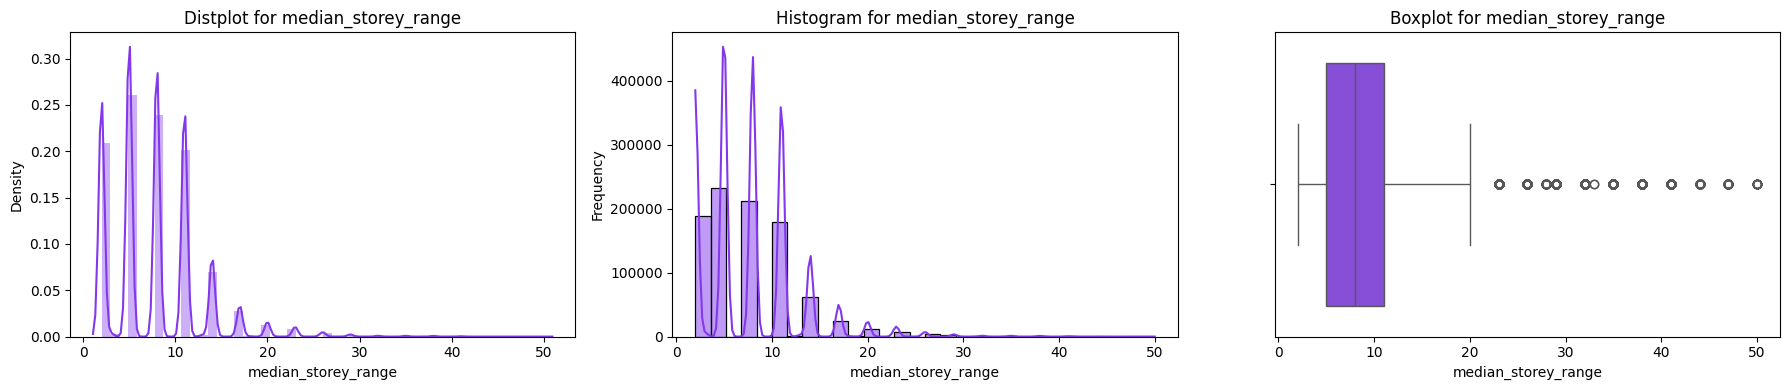

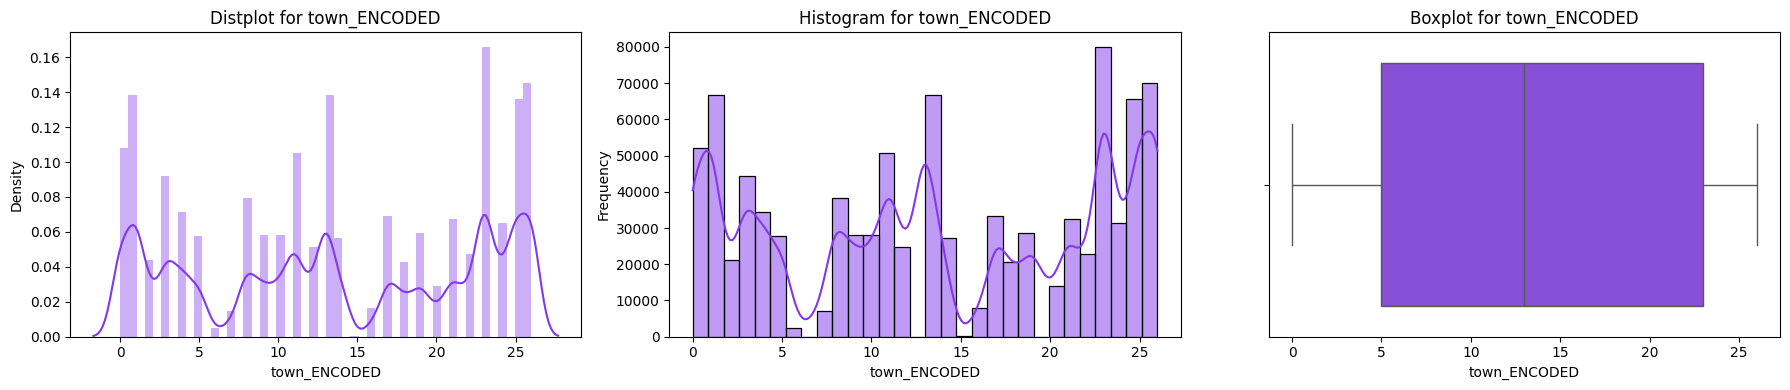

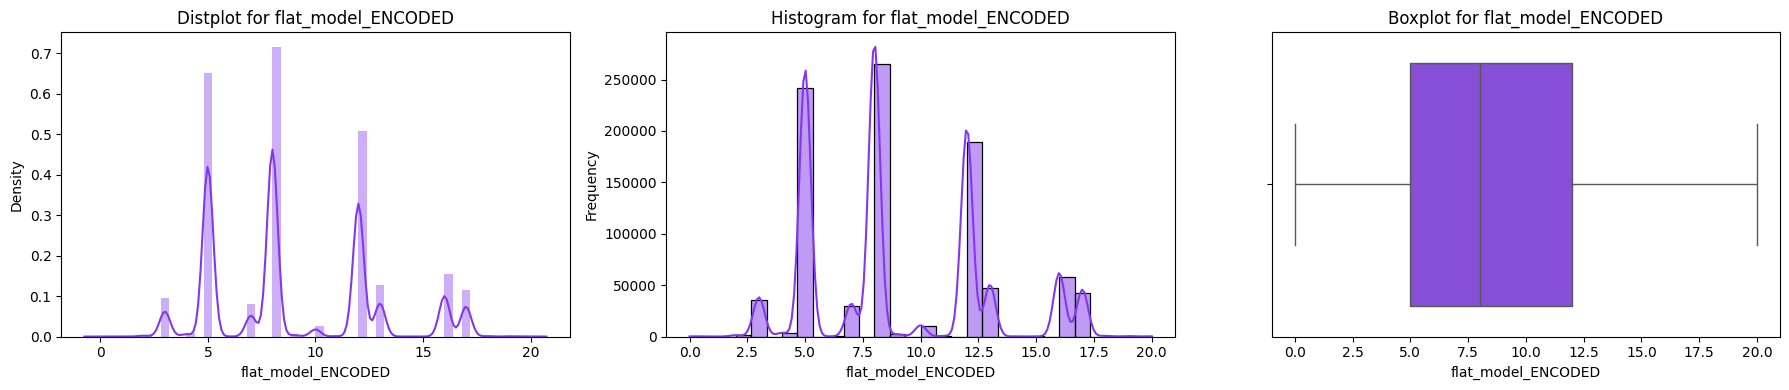

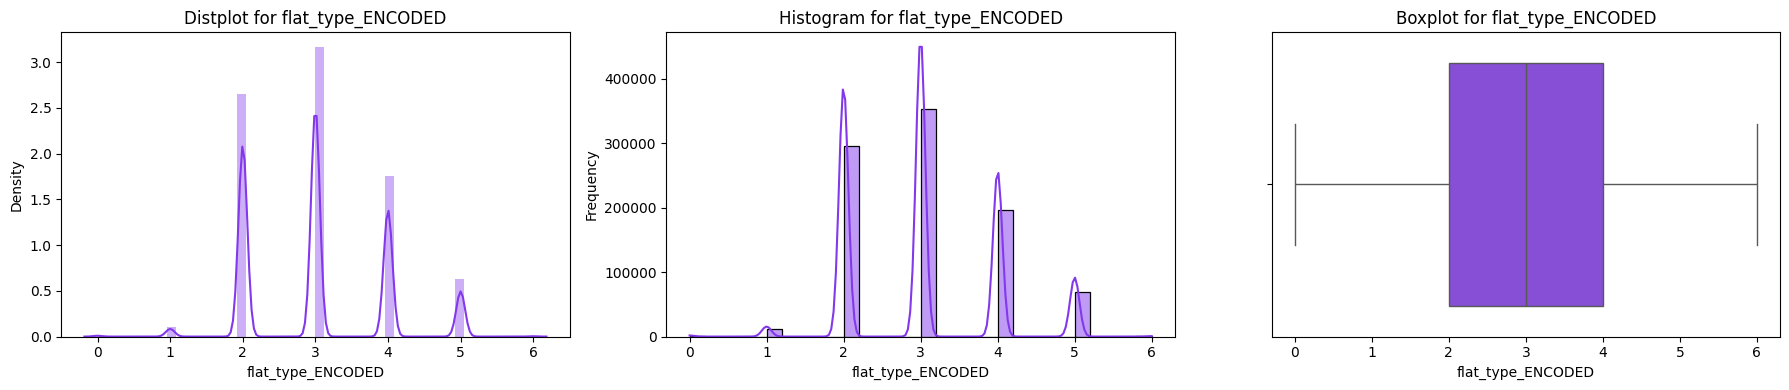

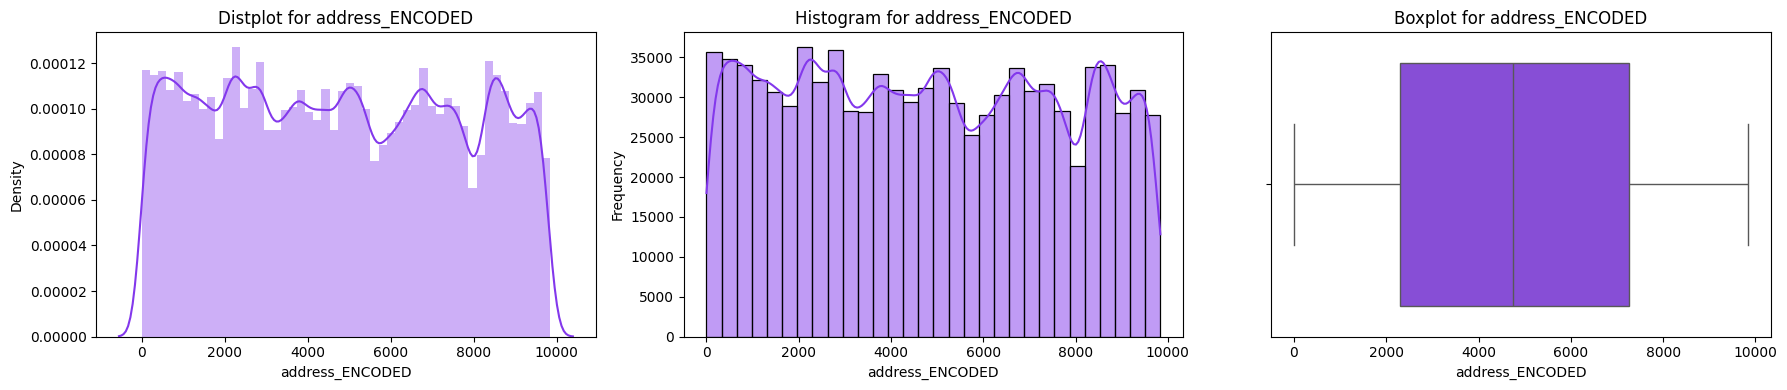

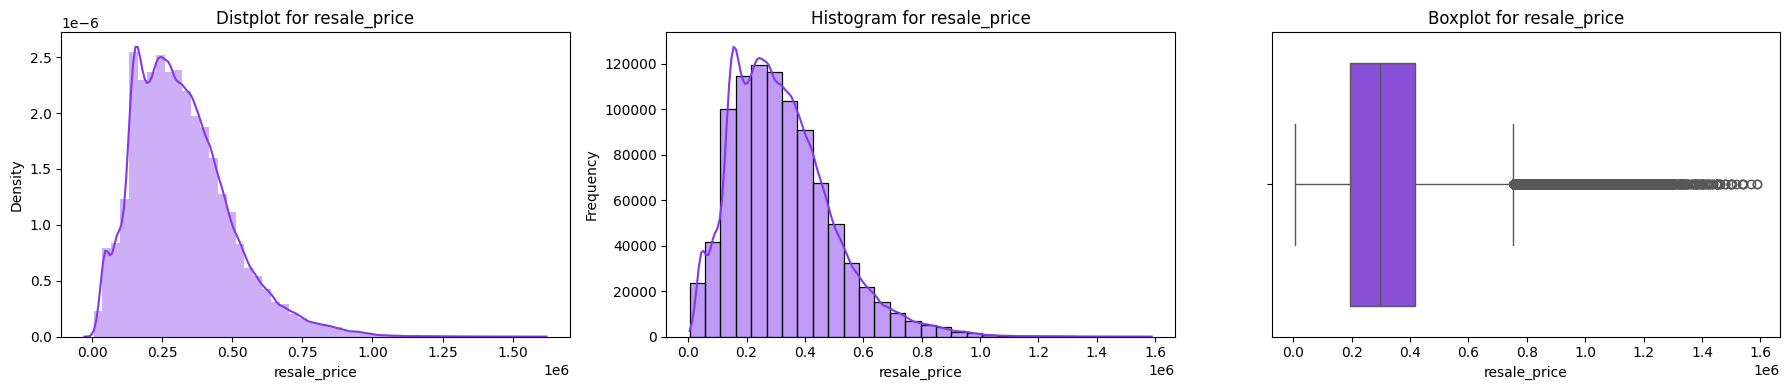

In [54]:
def plot(df, column):
    # Create a figure with three subplots
    plt.figure(figsize=(18, 4))

    # Distplot
    plt.subplot(1, 3, 1)
    sns.distplot(df[column], color='#8338ec', kde=True)
    plt.title("Distplot for " + column)
    plt.xlabel(column)
    plt.ylabel('Density')

    # Histogram plot
    plt.subplot(1, 3, 2)
    sns.histplot(df, x=column, kde=True, bins=30,color='#8338ec')
    plt.title("Histogram for " + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[column], color='#8338ec')
    plt.title("Boxplot for " + column)
    plt.xlabel(column)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Iterate through each column in model_data and plot
for col in model_data.columns:
    plot(model_data, col)

# skewed features
    -median_storay_range
    -floor_area_sqm
    -resale_price

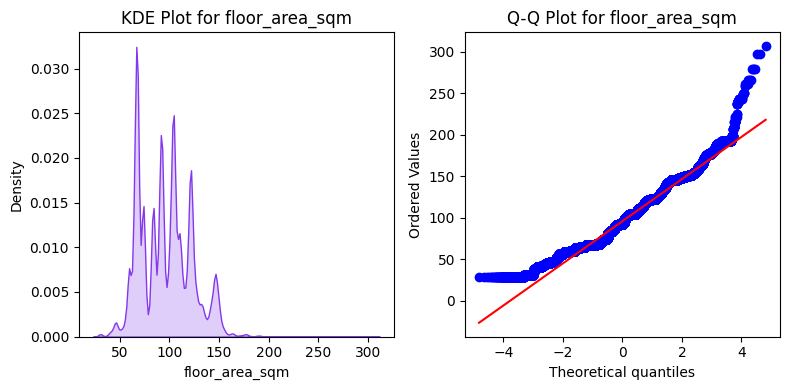

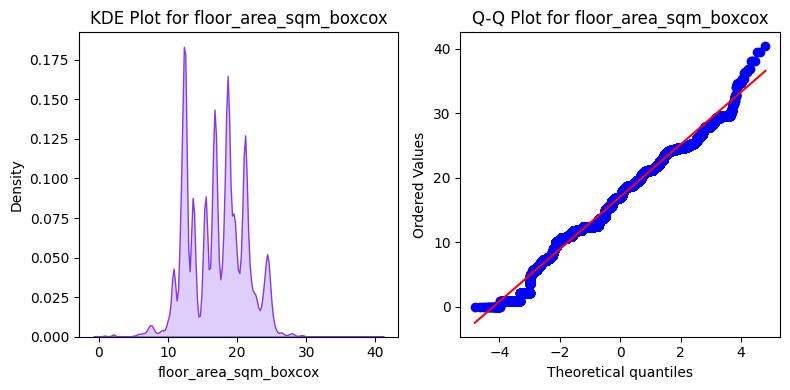

Original Skewness for floor_area_sqm: 0.36559030034520845
Box-Cox Transformed Skewness for floor_area_sqm: -0.02479612753282049



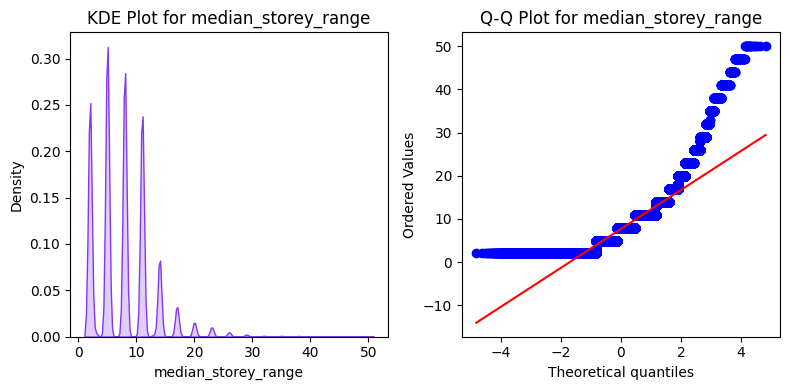

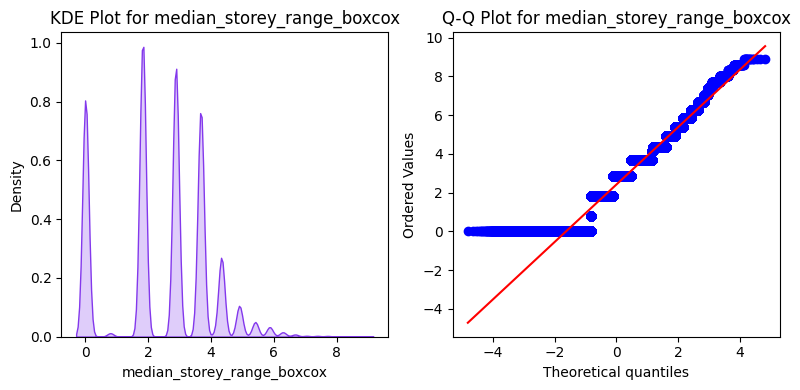

Original Skewness for median_storey_range: 1.354300037703691
Box-Cox Transformed Skewness for median_storey_range: -0.08304565324435399



In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pylab
from scipy.stats import boxcox

def plot_data(model_data, feature, transformed_feature_name):
    plt.figure(figsize=(8, 4))

    # KDE plot
    plt.subplot(1, 2, 1)
    sns.kdeplot(model_data[transformed_feature_name], shade=True,color='#8338ec')
    plt.title(f'KDE Plot for {transformed_feature_name}')
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    stat.probplot(model_data[transformed_feature_name], dist='norm', plot=pylab)
    plt.title(f'Q-Q Plot for {transformed_feature_name}')

    plt.tight_layout()
    plt.show()

def apply_transformations(model_data, feature):
    # Original plot
    plot_data(model_data, feature, feature)

    # Box-Cox transformation
    # Box-Cox requires all positive values, so we shift data if necessary
    positive_feature = model_data[feature] - model_data[feature].min() + 1
    model_data[f'{feature}_boxcox'], _ = boxcox(positive_feature)
    plot_data(model_data, feature, f'{feature}_boxcox')

    # Evaluate skewness after transformations
    print(f"Original Skewness for {feature}: {model_data[feature].skew()}")
    print(f"Box-Cox Transformed Skewness for {feature}: {model_data[f'{feature}_boxcox'].skew()}")
    print()

# Features to transform
features = ['floor_area_sqm','median_storey_range']

# Apply transformations to each feature
for feature in features:
    apply_transformations(model_data, feature)


In [56]:
model_data["resale_price"]= np.log(model_data["resale_price"])

In [57]:
model_data

,floor_area_sqm,lease_commence_date,remaining_lease,year,months,median_storey_range,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price,floor_area_sqm_boxcox,median_storey_range_boxcox
0,31.0,1977,86,1990,1,11,0,5.0,0.0,3835,9.104980,2.098669,3.671281
1,31.0,1977,86,1990,1,5,0,5.0,0.0,3835,8.699515,2.098669,1.822176
2,31.0,1977,86,1990,1,11,0,5.0,0.0,3835,8.987197,2.098669,3.671281
3,31.0,1977,86,1990,1,8,0,5.0,0.0,3835,8.699515,2.098669,2.874588
4,73.0,1976,85,1990,1,5,0,12.0,2.0,2373,10.762149,13.520167,1.822176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
929319,84.0,1987,62,2024,7,8,26,16.0,3.0,8478,13.122363,15.479220,2.874588
929320,132.0,1986,61,2024,7,8,26,5.0,4.0,8810,13.455974,22.548172,2.874588
929321,113.0,2018,93,2024,7,5,26,5.0,4.0,6354,13.444447,19.966787,1.822176
929322,112.0,2018,93,2024,7,2,26,5.0,4.0,8037,13.384728,19.824328,0.000000


#Outlayer feature are:

    -resale_price
    -median_storay_range
    -remaining_lease
    -floor_area_sqm
    -lease_commence_date

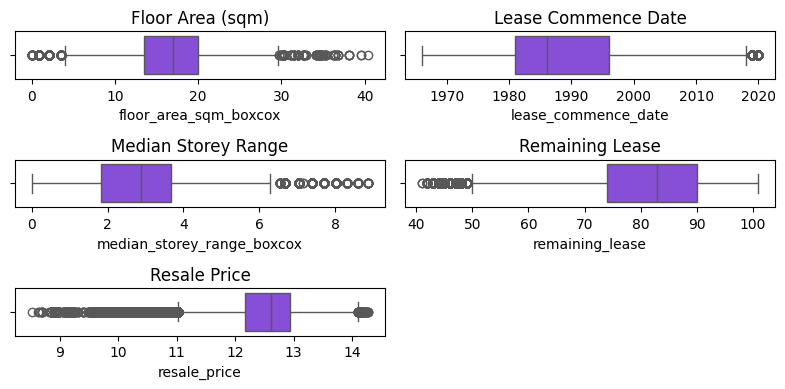

In [58]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(8, 4)

# Create boxplots
sns.boxplot(model_data['floor_area_sqm_boxcox'], orient='h', ax=axes[0][0],color='#8338ec')
sns.boxplot(model_data['lease_commence_date'], orient='h', ax=axes[0][1],color='#8338ec')
sns.boxplot(model_data['median_storey_range_boxcox'], orient='h', ax=axes[1][0],color='#8338ec')
sns.boxplot(model_data['remaining_lease'], orient='h', ax=axes[1][1],color='#8338ec')
sns.boxplot(model_data['resale_price'], orient='h', ax=axes[2][0],color='#8338ec')

# Set titles for each subplot
axes[0][0].set_title('Floor Area (sqm)')
axes[0][1].set_title('Lease Commence Date')
axes[1][0].set_title('Median Storey Range')
axes[1][1].set_title('Remaining Lease')
axes[2][0].set_title('Resale Price')
fig.delaxes(axes[2][1])
plt.tight_layout()
plt.show()

In [59]:
outlier_columns = ['floor_area_sqm_boxcox', 'lease_commence_date', 'median_storey_range_boxcox', 'remaining_lease','resale_price' ]
before_stats = model_data[outlier_columns].describe().T
before_stats

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm_boxcox,927352.0,17.042817,4.105824,0.000000,13.520167,16.961255,19.966787,40.435919
lease_commence_date,927352.0,1988.301714,10.682496,1966.000000,1981.000000,1986.000000,1996.000000,2020.000000
median_storey_range_boxcox,927352.0,2.418795,1.545938,0.000000,1.822176,2.874588,3.671281,8.872382
remaining_lease,927352.0,81.088209,10.734562,41.000000,74.000000,83.000000,90.000000,101.000000
resale_price,927352.0,12.521284,0.611765,8.517193,12.175613,12.604849,12.943237,14.277986


In [60]:
for column in outlier_columns:
    Q1 = model_data[column].quantile(0.25)
    Q3 = model_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    model_data[column] = model_data[column].clip(lower_bound, upper_bound)

# Calculate summary statistics after removing outliers
after_stats = model_data[outlier_columns].describe().T
after_stats

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm_boxcox,927352.0,17.045399,4.093359,3.850237,13.520167,16.961255,19.966787,29.636718
lease_commence_date,927352.0,1988.299598,10.676423,1966.000000,1981.000000,1986.000000,1996.000000,2018.500000
median_storey_range_boxcox,927352.0,2.415948,1.537501,0.000000,1.822176,2.874588,3.671281,6.444937
remaining_lease,927352.0,81.100176,10.697559,50.000000,74.000000,83.000000,90.000000,101.000000
resale_price,927352.0,12.532510,0.577091,11.024179,12.175613,12.604849,12.943237,14.094672


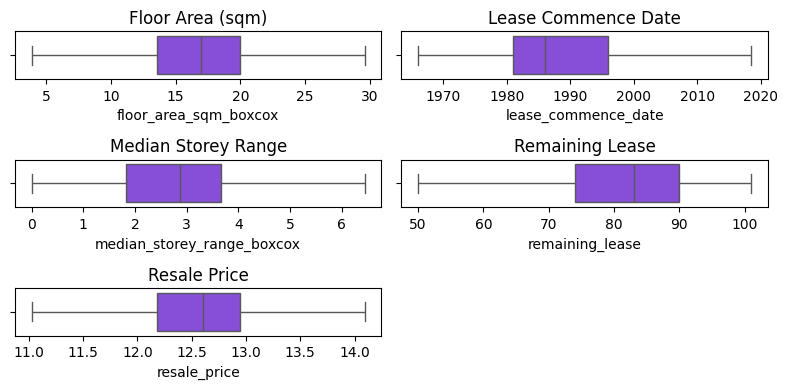

In [61]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(8, 4)

# Create boxplots
sns.boxplot(model_data['floor_area_sqm_boxcox'], orient='h', ax=axes[0][0],color='#8338ec')
sns.boxplot(model_data['lease_commence_date'], orient='h', ax=axes[0][1],color='#8338ec')
sns.boxplot(model_data['median_storey_range_boxcox'], orient='h', ax=axes[1][0],color='#8338ec')
sns.boxplot(model_data['remaining_lease'], orient='h', ax=axes[1][1],color='#8338ec')
sns.boxplot(model_data['resale_price'], orient='h', ax=axes[2][0],color='#8338ec')

# Set titles for each subplot
axes[0][0].set_title('Floor Area (sqm)')
axes[0][1].set_title('Lease Commence Date')
axes[1][0].set_title('Median Storey Range')
axes[1][1].set_title('Remaining Lease')
axes[2][0].set_title('Resale Price')
fig.delaxes(axes[2][1])
plt.tight_layout()
plt.show()

In [62]:
model_data.head(2)

,floor_area_sqm,lease_commence_date,remaining_lease,year,months,median_storey_range,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price,floor_area_sqm_boxcox,median_storey_range_boxcox
0,31.0,1977.0,86,1990,1,11,0,5.0,0.0,3835,11.024179,3.850237,3.671281
1,31.0,1977.0,86,1990,1,5,0,5.0,0.0,3835,11.024179,3.850237,1.822176


In [63]:
model = model_data[['floor_area_sqm_boxcox','lease_commence_date', 'remaining_lease', 'year', 'months','median_storey_range_boxcox','town_ENCODED','flat_model_ENCODED','flat_type_ENCODED','address_ENCODED','resale_price']]
model.head(2)

,floor_area_sqm_boxcox,lease_commence_date,remaining_lease,year,months,median_storey_range_boxcox,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price
0,3.850237,1977.0,86,1990,1,3.671281,0,5.0,0.0,3835,11.024179
1,3.850237,1977.0,86,1990,1,1.822176,0,5.0,0.0,3835,11.024179


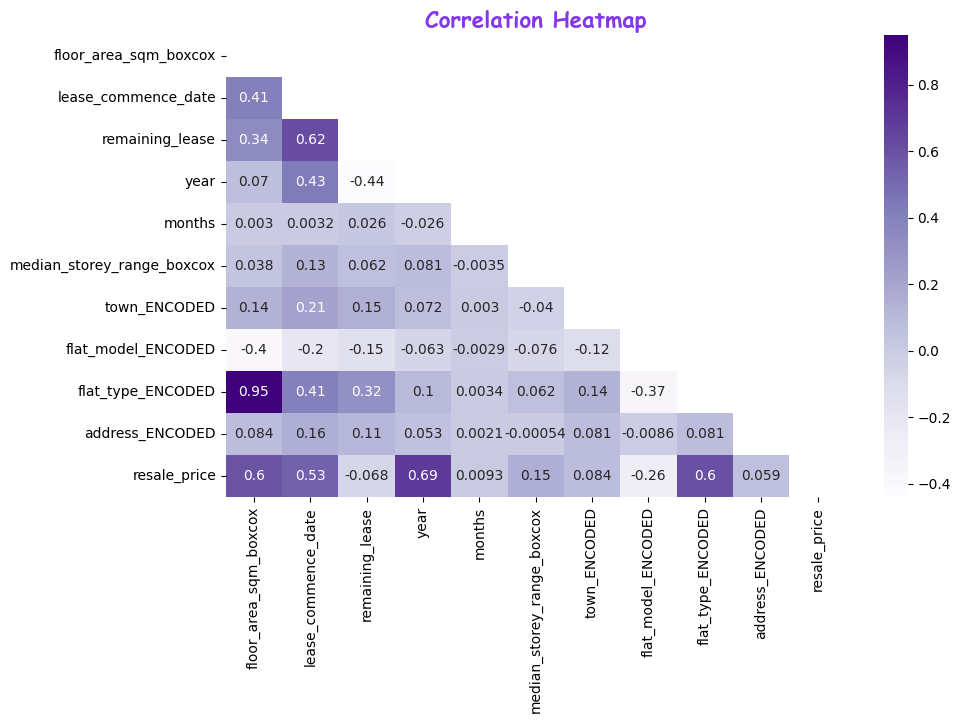

In [64]:
corr_matrix = model.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(corr_matrix, cmap="Purples", annot=True, mask=mask, ax=ax)

ax.set_title("Correlation Heatmap", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.tick_params(axis='both', colors='black')
plt.show()

In [65]:
model.tail(2)

,floor_area_sqm_boxcox,lease_commence_date,remaining_lease,year,months,median_storey_range_boxcox,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price
929322,19.824328,2018.0,93,2024,7,0.0,26,5.0,4.0,8037,13.384728
929323,24.320861,1985.0,60,2024,7,0.0,26,7.0,5.0,3378,13.554146


In [66]:
model = model.sample(n=100000, random_state=42)

In [67]:
model.tail()

,floor_area_sqm_boxcox,lease_commence_date,remaining_lease,year,months,median_storey_range_boxcox,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price
850671,21.217715,1999.0,77,2021,8,5.405657,5,5.0,4.0,6687,13.345507
72195,18.507472,1989.0,94,1994,6,2.874588,24,8.0,3.0,2958,12.128111
418793,15.136264,1976.0,72,2003,10,1.822176,24,5.0,3.0,2597,12.180755
516591,19.537189,2002.0,94,2007,3,4.329816,5,13.0,4.0,6031,12.542545
91657,16.639976,1985.0,89,1995,5,3.671281,1,12.0,3.0,214,12.154779


# Model Building

In [68]:
#model import
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

In [69]:

X= model.drop(columns=["resale_price"])
y= model["resale_price"]

scalled_data = StandardScaler().fit(X)
X = scalled_data.transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
models = {
    "ExtraTreeRegressor": ExtraTreesRegressor(),
    'XGBRegressor': XGBRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor()
}

n = X_test.shape[0]  # number of samples
p = X_test.shape[1]  # number of predictors

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    train_MSE = mean_squared_error(y_train, y_train_pred)
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    train_R2 = r2_score(y_train, y_train_pred)
    train_Adjusted_R2 = 1 - ((1 - train_R2) * (n - 1) / (n - p - 1))
    
    test_MSE = mean_squared_error(y_test, y_pred)
    test_MAE = mean_absolute_error(y_test, y_pred)
    test_R2 = r2_score(y_test, y_pred)
    test_Adjusted_R2 = 1 - ((1 - test_R2) * (n - 1) / (n - p - 1))
    
    print("+-----------------------------------+")
    print(f"   -- {model_name} --    ")
    print("+-----------------------------------+")
    print("| Model performance on training set |")
    print("+-----------------------------------+")
    print(f"|         train_MSE : {train_MSE:.4f}        |")
    print(f"|         train_MAE : {train_MAE:.4f}        |")
    print(f"|         train_R2  : {train_R2:.4f}        |")
    print(f"| train_Adjusted R2 : {train_Adjusted_R2:.4f}        |")
    print("+-----------------------------------+")
    print("+-----------------------------------+")
    print(f"   -- {model_name} --    ")
    print("+-----------------------------------+")
    print("| Model performance on testing set |")
    print("+-----------------------------------+")
    print(f"|         test_MSE : {test_MSE:.4f}        |")
    print(f"|         test_MAE : {test_MAE:.4f}        |")
    print(f"|         test_R2  : {test_R2:.4f}        |")
    print(f"| test_Adjusted R2 : {test_Adjusted_R2:.4f}        |")
    print("+-----------------------------------+")
    print('='*36)


+-----------------------------------+
   -- ExtraTreeRegressor --    
+-----------------------------------+
| Model performance on training set |
+-----------------------------------+
|         train_MSE : 0.0000        |
|         train_MAE : 0.0001        |
|         train_R2  : 1.0000        |
| train_Adjusted R2 : 1.0000        |
+-----------------------------------+
+-----------------------------------+
   -- ExtraTreeRegressor --    
+-----------------------------------+
| Model performance on testing set |
+-----------------------------------+
|         test_MSE : 0.0101     |
|         test_MAE : 0.0712       |
|         test_R2  : 0.9700        |
| test_Adjusted R2 : 0.9700        |
+-----------------------------------+
+-----------------------------------+
   -- XGBRegressor --    
+-----------------------------------+
| Model performance on training set |
+-----------------------------------+
|         train_MSE : 0.0052        |
|         train_MAE : 0.0538        |
|      

In [71]:
# from sklearn.model_selection import GridSearchCV

# Xg_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 1.0],
#     'min_child_weight': [1, 3, 5]
# }
# gridcv_models = [("XG", XGBRegressor(), Xg_param_grid )]
# gridcv_models

In [72]:
# model_param = {}
# for name, model, params in gridcv_models:
#     grid_search  = GridSearchCV(estimator=model,
#                                param_grid=params,
#                                cv=3,
#                                verbose=2,
#                                n_jobs=-1
#                               )
#     grid_search.fit(X_train, y_train)
#     model_param[name] = grid_search.best_params_
    
# for model_name in model_param:
#     print(f"===========Best Params for {model_name}===========")
#     print(model_param[model_name])

In [73]:
models = {
    'XGBRegressor': XGBRegressor(
                                colsample_bytree=0.8,
                                 learning_rate=0.1, 
                                # max_depth=5, 
                                min_child_weight=5,
                                 n_estimators=300,
                             #  reg_alpha=0.5,
                             reg_lambda=1.0,
                               subsample=0.8
                                 )
}

n = X_test.shape[0]  # number of samples
p = X_test.shape[1]  # number of predictors

for model_name, final_model in models.items():
    final_model.fit(X_train, y_train)
    
    y_train_pred = final_model.predict(X_train)
    y_pred = final_model.predict(X_test)
    
    train_MSE = mean_squared_error(y_train, y_train_pred)
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    train_R2 = r2_score(y_train, y_train_pred)
    train_Adjusted_R2 = 1 - ((1 - train_R2) * (n - 1) / (n - p - 1))
    
    test_MSE = mean_squared_error(y_test, y_pred)
    test_MAE = mean_absolute_error(y_test, y_pred)
    test_R2 = r2_score(y_test, y_pred)
    test_Adjusted_R2 = 1 - ((1 - test_R2) * (n - 1) / (n - p - 1))
    
    print("+-----------------------------------+")
    print(f"          -- {model_name} --    ") 
    print("+-----------------------------------+")
    print("| Model performance on training set |")
    print("+-----------------------------------+")
    print(f"|         train_MSE : {train_MSE:.4f}      |")
    print(f"|         train_MAE : {train_MAE:.4f}        |")
    print(f"|         train_R2  : {train_R2:.4f}        |")
    print(f"| train_Adjusted R2 : {train_Adjusted_R2:.4f}        |")
    print("+-----------------------------------+")
    print("+-----------------------------------+")
    print(f"         -- {model_name} --    ")
    print("+-----------------------------------+")
    print("| Model performance on testing set  |")
    print("+-----------------------------------+")
    print(f"|         test_MSE : {test_MSE:.4f}       |")
    print(f"|         test_MAE : {test_MAE:.4f}        |")
    print(f"|         test_R2  : {test_R2:.4f}         |")
    print(f"| test_Adjusted R2 : {test_Adjusted_R2:.4f}         |")
    print("+-----------------------------------+")
    print('='*36)


+-----------------------------------+
          -- XGBRegressor --    
+-----------------------------------+
| Model performance on training set |
+-----------------------------------+
|         train_MSE : 0.0051      |
|         train_MAE : 0.0526        |
|         train_R2  : 0.9849        |
| train_Adjusted R2 : 0.9849        |
+-----------------------------------+
+-----------------------------------+
         -- XGBRegressor --    
+-----------------------------------+
| Model performance on testing set  |
+-----------------------------------+
|         test_MSE : 0.0062       |
|         test_MAE : 0.0572        |
|         test_R2  : 0.9817         |
| test_Adjusted R2 : 0.9817         |
+-----------------------------------+


In [74]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
scaler.fit(X_train)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
XG_model = XGBRegressor(colsample_bytree=0.8,learning_rate=0.1,min_child_weight=5,n_estimators=500, reg_lambda=1.0, subsample=0.8)

xg_regression_model=XG_model.fit(X_train, y_train)

with open('xg_regression_model.pkl', 'wb') as file:
    pickle.dump(xg_regression_model, file)

In [151]:
import pandas as pd
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


# Load the pre-trained encoders
with open('town_encoder.pkl', 'rb') as f:
    town_encoder = pickle.load(f)
with open('flat_model_encoder.pkl', 'rb') as f:
    flat_model_encoder = pickle.load(f)
with open('flat_type_encoder.pkl', 'rb') as f:
    flat_type_encoder = pickle.load(f)
with open('address_encoder.pkl', 'rb') as f:
    address_encoder = pickle.load(f)


def data_transformation_for_the_model(df):
    def to_upper(df):
        string_cols = df.select_dtypes(include='object').columns
        df[string_cols] = df[string_cols].apply(lambda x: x.str.upper())
        return df
    
    def apply_transformations(user_input_df):
        # Transform features
        features = ['floor_area_sqm', 'median_storey_range']
        for feature in features:
            positive_feature = user_input_df[feature] - user_input_df[feature].min() + 1
            if len(positive_feature.unique()) > 1:
                transformed_feature, _ = boxcox(positive_feature)
                user_input_df[f'{feature}_boxcox'] = transformed_feature
            else:
                user_input_df[f'{feature}_boxcox'] = positive_feature  # Skip Box-Cox if data is constant
        return user_input_df

    df = (df
            .pipe(to_upper)
            .assign(remaining_lease=lambda x: x['lease_commence_date'] + 99 - x['year'],
                    town_ENCODED=lambda x: town_encoder.transform(x["town"]),
                    flat_model_ENCODED=lambda x: flat_model_encoder.transform(x[["flat_model"]]).flatten(),
                    flat_type_ENCODED=lambda x: flat_type_encoder.transform(x[["flat_type"]]).flatten(),
                    address_ENCODED=lambda x: address_encoder.transform(x["address"]))
            .assign(median_storey_range=lambda x: x['storey_range'].apply(lambda storey_range: (int(storey_range.split(' TO ')[0]) + int(storey_range.split(' TO ')[1])) / 2).astype(int))
            .pipe(apply_transformations)
            [['floor_area_sqm_boxcox', 'lease_commence_date', 'remaining_lease', 'year', 'months', 'median_storey_range_boxcox', 
            'town_ENCODED', 'flat_model_ENCODED', 'flat_type_ENCODED', 'address_ENCODED']]         
            )
    return df

new_data = {
    'floor_area_sqm': [146.0,84.0],
    'lease_commence_date': [1985, 1987],
    'year': [2024, 2024],
    'months': [7, 7],
    'storey_range': ['1 TO 2', '7 TO 9'],
    'town': ['YISHUN', 'YISHUN'],
    'flat_model': ['MAISONETTE', 'SIMPLIFIED'],
    'flat_type': ['EXECUTIVE', '5 ROOM'],
    'address': ['277 YISHUN ST 22', '719 YISHUN ST 71']
}

new_df = pd.DataFrame(new_data)

ready_to_predict = data_transformation_for_the_model(new_df)
ready_to_predict

,floor_area_sqm_boxcox,lease_commence_date,remaining_lease,year,months,median_storey_range_boxcox,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED
0,4.143115,1985,60,2024,7,0.000000,26,7.0,5.0,3378
1,0.000000,1987,62,2024,7,2.079445,26,16.0,4.0,8478


In [160]:
import pickle
# Load the trained scaler
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Scale the features
scaled_features = scaler.transform(ready_to_predict)

# Load the trained model
with open('xg_regression_model.pkl', 'rb') as file:
    final_model = pickle.load(file)

# Make predictions
predicted_price = final_model.predict(scaled_features) 

range1 = predicted_price - 1
lower_range_exp = np.exp(range1)
predicted_price_exp = np.exp(predicted_price)

# Create a formatted string for the range
ranges_str = ', '.join([f"${lower:.2f} - ${upper:.2f}" for lower, upper in zip(lower_range_exp, predicted_price_exp)])

ranges_str

'$487963.91 - $1326423.38, $321470.84 - $873848.38'

In [153]:
cleaned_data.tail(5)

,floor_area_sqm,lease_commence_date,remaining_lease,year,months,median_storey_range,town,flat_model,flat_type,address,resale_price
929319,84.0,1987,62,2024,7,8,YISHUN,SIMPLIFIED,4 ROOM,719 YISHUN ST 71,500000.0
929320,132.0,1986,61,2024,7,8,YISHUN,IMPROVED,5 ROOM,776 YISHUN AVE 2,698000.0
929321,113.0,2018,93,2024,7,5,YISHUN,IMPROVED,5 ROOM,508B YISHUN AVE 4,690000.0
929322,112.0,2018,93,2024,7,2,YISHUN,IMPROVED,5 ROOM,674B YISHUN AVE 4,650000.0
929323,146.0,1985,60,2024,7,2,YISHUN,MAISONETTE,EXECUTIVE,277 YISHUN ST 22,770000.0


In [79]:
model_data

,floor_area_sqm,lease_commence_date,remaining_lease,year,months,median_storey_range,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,address_ENCODED,resale_price,floor_area_sqm_boxcox,median_storey_range_boxcox
0,31.0,1977.0,86,1990,1,11,0,5.0,0.0,3835,11.024179,3.850237,3.671281
1,31.0,1977.0,86,1990,1,5,0,5.0,0.0,3835,11.024179,3.850237,1.822176
2,31.0,1977.0,86,1990,1,11,0,5.0,0.0,3835,11.024179,3.850237,3.671281
3,31.0,1977.0,86,1990,1,8,0,5.0,0.0,3835,11.024179,3.850237,2.874588
4,73.0,1976.0,85,1990,1,5,0,12.0,2.0,2373,11.024179,13.520167,1.822176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
929319,84.0,1987.0,62,2024,7,8,26,16.0,3.0,8478,13.122363,15.479220,2.874588
929320,132.0,1986.0,61,2024,7,8,26,5.0,4.0,8810,13.455974,22.548172,2.874588
929321,113.0,2018.0,93,2024,7,5,26,5.0,4.0,6354,13.444447,19.966787,1.822176
929322,112.0,2018.0,93,2024,7,2,26,5.0,4.0,8037,13.384728,19.824328,0.000000


In [78]:
import pickle
import pandas as pd
import numpy as np
import streamlit as st
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from scipy.stats import boxcox

st.set_page_config(page_title="Singapore Resale Flat Price Prediction - Made by: Naveen A", layout="wide", initial_sidebar_state="auto")        

# Load the pre-trained encoders
with open('town_encoder.pkl', 'rb') as f:
    town_encoder = pickle.load(f)
with open('flat_model_encoder.pkl', 'rb') as f:
    flat_model_encoder = pickle.load(f)
with open('flat_type_encoder.pkl', 'rb') as f:
    flat_type_encoder = pickle.load(f)
with open('address_encoder.pkl', 'rb') as f:
    address_encoder = pickle.load(f)
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Mapping dictionaries
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

storey = ['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12', '11 TO 15', '13 TO 15', 
          '16 TO 18', '16 TO 20', '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30', 
          '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40', '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', 
          '49 TO 51']

all_addresses = address_encoder.classes_.tolist()
all_towns  = town_encoder.classes_.tolist()
all_flat_model = flat_model_encoder.categories_[0].tolist()
flat_type_mapping  = flat_type_encoder.categories_[0].tolist()

def get_user_input():
    
    st.subheader(":violet[Fill all the fields and press the button below to view the **Predicted price** of Resale Flat Price : ]")
    cc1, cc2 = st.columns([2, 2])
    
    with cc1:    
        floor_area_sqm = st.number_input("Floor Area (sqm) : ")
        lease_commence_date = st.number_input("Lease Commencement Year (YYYY) : ", min_value=1966, max_value=2023)
        year = st.number_input("Year (YYYY) : ", min_value=1990, max_value=2023)
        month = st.selectbox("Month : ", list(month_mapping.keys()))     
    with cc2:  
        storey_range = st.selectbox("Storey Range : ", storey)
        town = st.selectbox("Town : ", all_towns)
        flat_model = st.selectbox("Flat Model : ", all_flat_model)
        flat_type = st.selectbox("Flat Type : ", list(flat_type_mapping))
        address = st.selectbox('Enter the Address with Block Number with Street name :', all_addresses)

    # Create a DataFrame with user inputs
    user_input_data = {
        'floor_area_sqm': floor_area_sqm,
        'lease_commence_date': lease_commence_date,
        'year': year,
        'month': month_mapping[month],
        'storey_range': storey_range,
        'town': town,
        'flat_model': flat_model,
        'flat_type': flat_type,
        'address': address }
    
    return pd.DataFrame(user_input_data, index=[0])

def load_model():
    with open('xg_regression_model.pkl', 'rb') as file:
        final_model = pickle.load(file)
    return final_model

def data_transformation_for_the_model(df):
    
    def to_upper(df):
        string_cols = df.select_dtypes(include='object').columns
        df[string_cols] = df[string_cols].apply(lambda x: x.str.upper())
        return df
    
    df = (df
          .pipe(to_upper)
          .assign(remaining_lease=lambda x: x['lease_commence_date'] + 99 - x['year'],
                  town_ENCODED=lambda x: town_encoder.transform(x["town"]),
                  flat_model_ENCODED=lambda x: flat_model_encoder.transform(x[["flat_model"]]).flatten(),
                  flat_type_ENCODED=lambda x: flat_type_encoder.transform(x[["flat_type"]]).flatten(),
                  address_ENCODED=lambda x: address_encoder.transform(x["address"]))
          .assign(median_storey_range=lambda x: x['storey_range'].apply(lambda storey_range: (int(storey_range.split(' TO ')[0]) + int(storey_range.split(' TO ')[1])) / 2).astype(int))
          [['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'year', 'month', 'median_storey_range', 
            'town_ENCODED', 'flat_model_ENCODED', 'flat_type_ENCODED', 'address_ENCODED']]
          )

    # Scale the features
    df_scaled = scaler.transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)
    
    return df

def main():
    
    with st.sidebar: 
        st.image("https://www.onepointltd.com/wp-content/uploads/2020/03/inno2.png")
        st.title("Select options")
        choice = st.radio("Navigation", ["Home","Model"])
        st.info("This project application helps you predict the price and status")
    
    if choice == "Home":
        st.title("Welcome to the Singapore Resale Flat Price Prediction App")
    
        st.subheader("About the App")
        st.write("- Welcome to our interactive application designed to predict resale flat prices in Singapore. Whether you're a prospective buyer, seller, or simply curious about property trends, our app provides accurate predictions based on advanced machine learning models.")
        
        st.subheader("Key Features")
        st.markdown("- **Predictive Power**: Utilizing state-of-the-art machine learning algorithms, our app forecasts resale flat prices with high precision, leveraging historical data and real-time trends.")
        st.markdown("- **User-Friendly Interface**: Designed for ease of use, our intuitive interface allows you to input key parameters and receive instant predictions, making informed decisions simpler than ever.")
        st.markdown("- **Customizable Inputs**: Tailor predictions by adjusting parameters such as floor area, lease commencement year, town, flat model, and more, ensuring personalized results.")
        st.markdown("- **Insightful Visualizations**: Explore trends and patterns in resale flat prices through interactive charts and graphs, providing deeper insights into the market dynamics.")
        
        st.subheader("How It Works")
        st.markdown("1. **Input Your Details**: Enter details such as floor area, lease commencement year, town, flat model, and other relevant parameters.")
        st.markdown("2. **Receive Predictions**: Our app processes your inputs through advanced machine learning models to generate accurate predictions of resale flat prices.")
        st.markdown("3. **Explore Insights**: Gain valuable insights into factors influencing resale flat prices and make informed decisions based on reliable forecasts.")
        
        st.subheader("Get Started")
        st.write("Ready to explore the future of resale flat prices in Singapore? Click on the sidebar to begin predicting or explore more about how our app can benefit you.")
        
        st.subheader("Why Choose Us?")
        st.markdown("- **Expertise**: Developed by seasoned data scientists specializing in real estate analytics, ensuring reliable predictions.")
        st.markdown("- **Accuracy**: Backed by rigorous model training and validation, our predictions are among the most accurate in the industry.")
        
        st.subheader("Testimonials")
        st.markdown('"Using the app helped me understand the market better and make smarter investment decisions." - Real Estate Investor')
        st.markdown('"Highly recommend for anyone looking to buy or sell property in Singapore!" - Homeowner')
        
        st.subheader('**created by** \n Naveen Anandhan')

    if choice == "Model":
        st.title(":violet[Singapore Resale Flat Price Prediction]")
        user_input_data = get_user_input()

        if st.button("Predict"):
            df = data_transformation_for_the_model(user_input_data)
            model = load_model()
            predicted_price = model.predict(df)
            range1 = predicted_price - 1  
            lower_range_exp = np.exp(range1)
            predicted_price_exp = np.exp(predicted_price)
            ranges_str = ', '.join([f"{lower:.2f} - {upper:.2f}" for lower, upper in zip(lower_range_exp, predicted_price_exp)])
            st.success(f'**Predicted Resale Price Range : :green[$] :green[{ranges_str}]   with 100% Accuracy**')
            

if __name__ == "__main__":
    main()
